# Validation

This notebook will compare the outputs of measurements done with napari-stress to those of the legacy-version [STRESS](https://github.com/campaslab/STRESS). The analysis usually comprises two steps - reconstruction of the droplet and the stress measurement - we treat these separately in this respect.

We compare **three analysis workflows**:

* Using the reconstruction and the measurement from STRESS
* Using the napari-stress reconstruction and the measurement from STRESS
* using the napari-stress reconstruction and the measurement from napari-stress

We compare the reconstruction and measured quantities for the following **synthetic data**:

* Ideal sphere

## Comparisons:

For all workflows, we compare the following quantities:

* The reconstructed pointcloud: Since the reconstructed object should be perfectly spherical, we can convert the reconstructed pointcloud coordinates to [spherical coordinates](https://en.wikipedia.org/wiki/Spherical_coordinate_system) and compare the distribution of radii of both reconstructions. 
* Measured mean curvatures: Similar to the distribution of measured radii, the measured mean curvatures should follow a similar and ideally narrow distributioin
* Total [stress anisotropies](https://www.biorxiv.org/content/10.1101/2021.03.26.437148v1.full): For an ideal sphere, these should be as close to zero as possible.

## Theoretical mean curvature


Mean curvature $H$ on an ellipse is given by the [following formula](https://mathworld.wolfram.com/Ellipsoid.html):

$H = \frac{a b c [3(a^2+b^2) + 2c^2 + (a^2 + b^2 -2c^2)cos(2\theta) - 2(a^2 - b^2)cos(2\phi)sin^2(\theta)]}{8[a^2b^2cos^2(\theta) + c^2(b^2 cos^2(\phi) + a^2 sin^2 (\phi)) sin^2\theta]^{3/2}}$

where a, b and c are the major axis length of the ellipsoid. The angles $\phi$ and $\theta$ denote the location on the surface of the ellipsoid in polar coordinates (latitude $\phi \in [0, 2\pi]$, longitude $\theta \in [0, \pi]$). We can thus compare all measurements of mean curvature on an ellipsoid (and thus, on a sphere) to the "true" mean curvature.



In [85]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import napari
import pandas as pd
import vedo
import seaborn as sns

In [86]:
def theoretical_mean_curvature_on_pointcloud(a, b, c, pointcloud) -> float:
    """Theoretical mean curvature of an ellipsoid.

    Parameters
    ----------
    a : float
        Length of the first semi-axis.
    b : float
        Length of the second semi-axis.
    c : float
        Length of the third semi-axis.
    theta : float
        Angular position of sample on ellipsoid surface
    phi : float
        Angular position of sample on ellipsoid surface
    """
    pointcloud_centered = pointcloud - pointcloud.mean(axis=0)[None, :]
    pointcloud_spherical = vedo.cart2spher(*pointcloud_centered.T).T
    mean_curvatures = []
    for pt in pointcloud_spherical:
        
        theta = pt[1]
        phi = pt[2]
        above = a * b * c * (3 * (a**2 + b**2) + 2*c**2 + (a**2 + b**2 - 2*c**2)*np.cos(2*theta) - 2*(a**2 - b**2)*np.cos(2*phi) * np.sin(theta)**2)
        below = 8 * (a**2 * b**2 *np.cos(theta)**2 + c**2 * (b**2 * np.cos(phi)**2 + a**2 * np.sin(phi)**2) * np.sin(theta)**2)**(3/2)
        mean_curvatures.append(above / below)
    return np.asarray(mean_curvatures)

In [87]:
viewer = napari.Viewer()

# Sphere

In [88]:
dataset = os.path.join('.', 'results_sphere')

In [89]:
pointcloud_stress0 = pd.read_csv(os.path.join(dataset, 'stress_analysis_and_stress_pointcloud', 'pointcloud.csv'), sep=',', header=None).to_numpy()
pointcloud_napari_stress0 = pd.read_csv(os.path.join(dataset, 'napari_stress_analysis_and_napari_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()

### Radii

We can measure the offsets of the two pointclouds:

In [90]:
offset = pointcloud_stress0.mean(axis=0) - pointcloud_napari_stress0.mean(axis=0)
offset

array([ 0.77227208,  0.9397048 , -0.08352071])

To compare the two pointcouds, we can convert both to relative coordinates by subtracting the pointcloud's center from every point:

In [91]:
pointcloud_stress0_centered = pointcloud_stress0 - pointcloud_stress0.mean(axis=0)[None, :]
pointcloud_napari_stress0_centered = pointcloud_napari_stress0 - pointcloud_napari_stress0.mean(axis=0)[None, :]

We can convert the points into spherical coordinates and measure the distribution of radii:

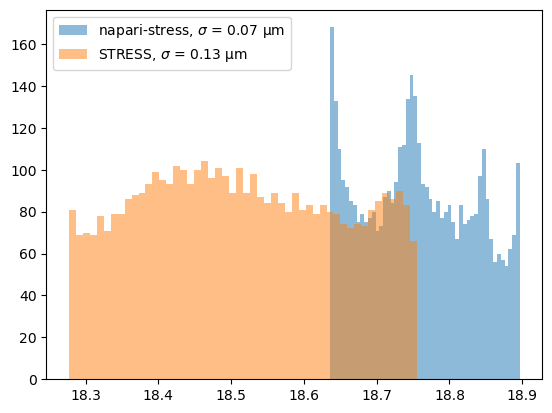

In [92]:
r_ns, phi_ns, theta_ns = vedo.cart2spher(pointcloud_napari_stress0_centered[:, 0], pointcloud_napari_stress0_centered[:, 1], pointcloud_napari_stress0_centered[:, 2])
r_s, phi_s, theta_s = vedo.cart2spher(pointcloud_stress0_centered[:, 0], pointcloud_stress0_centered[:, 1], pointcloud_stress0_centered[:, 2])

mpl.style.use('default')
fig, ax = plt.subplots()
ax.hist(r_ns, 50, label='napari-stress, $\sigma$ = {:.2f} µm'.format(r_ns.std()), alpha=0.5)
ax.hist(r_s, 50, label='STRESS, $\sigma$ = {:.2f} µm'.format(r_s.std()), alpha=0.5)
ax.legend()

In [93]:
for layer in viewer.layers:
    layer.visible = False
viewer.add_points(pointcloud_napari_stress0_centered, properties={'radius': r_ns}, face_color='radius', size=1)
viewer.add_points(pointcloud_stress0_centered, properties={'radius': r_s}, face_color='radius', size=1)

<Points layer 'pointcloud_stress0_centered' at 0x2960269f0a0>

For napari-stress, you see some small variations across the surface

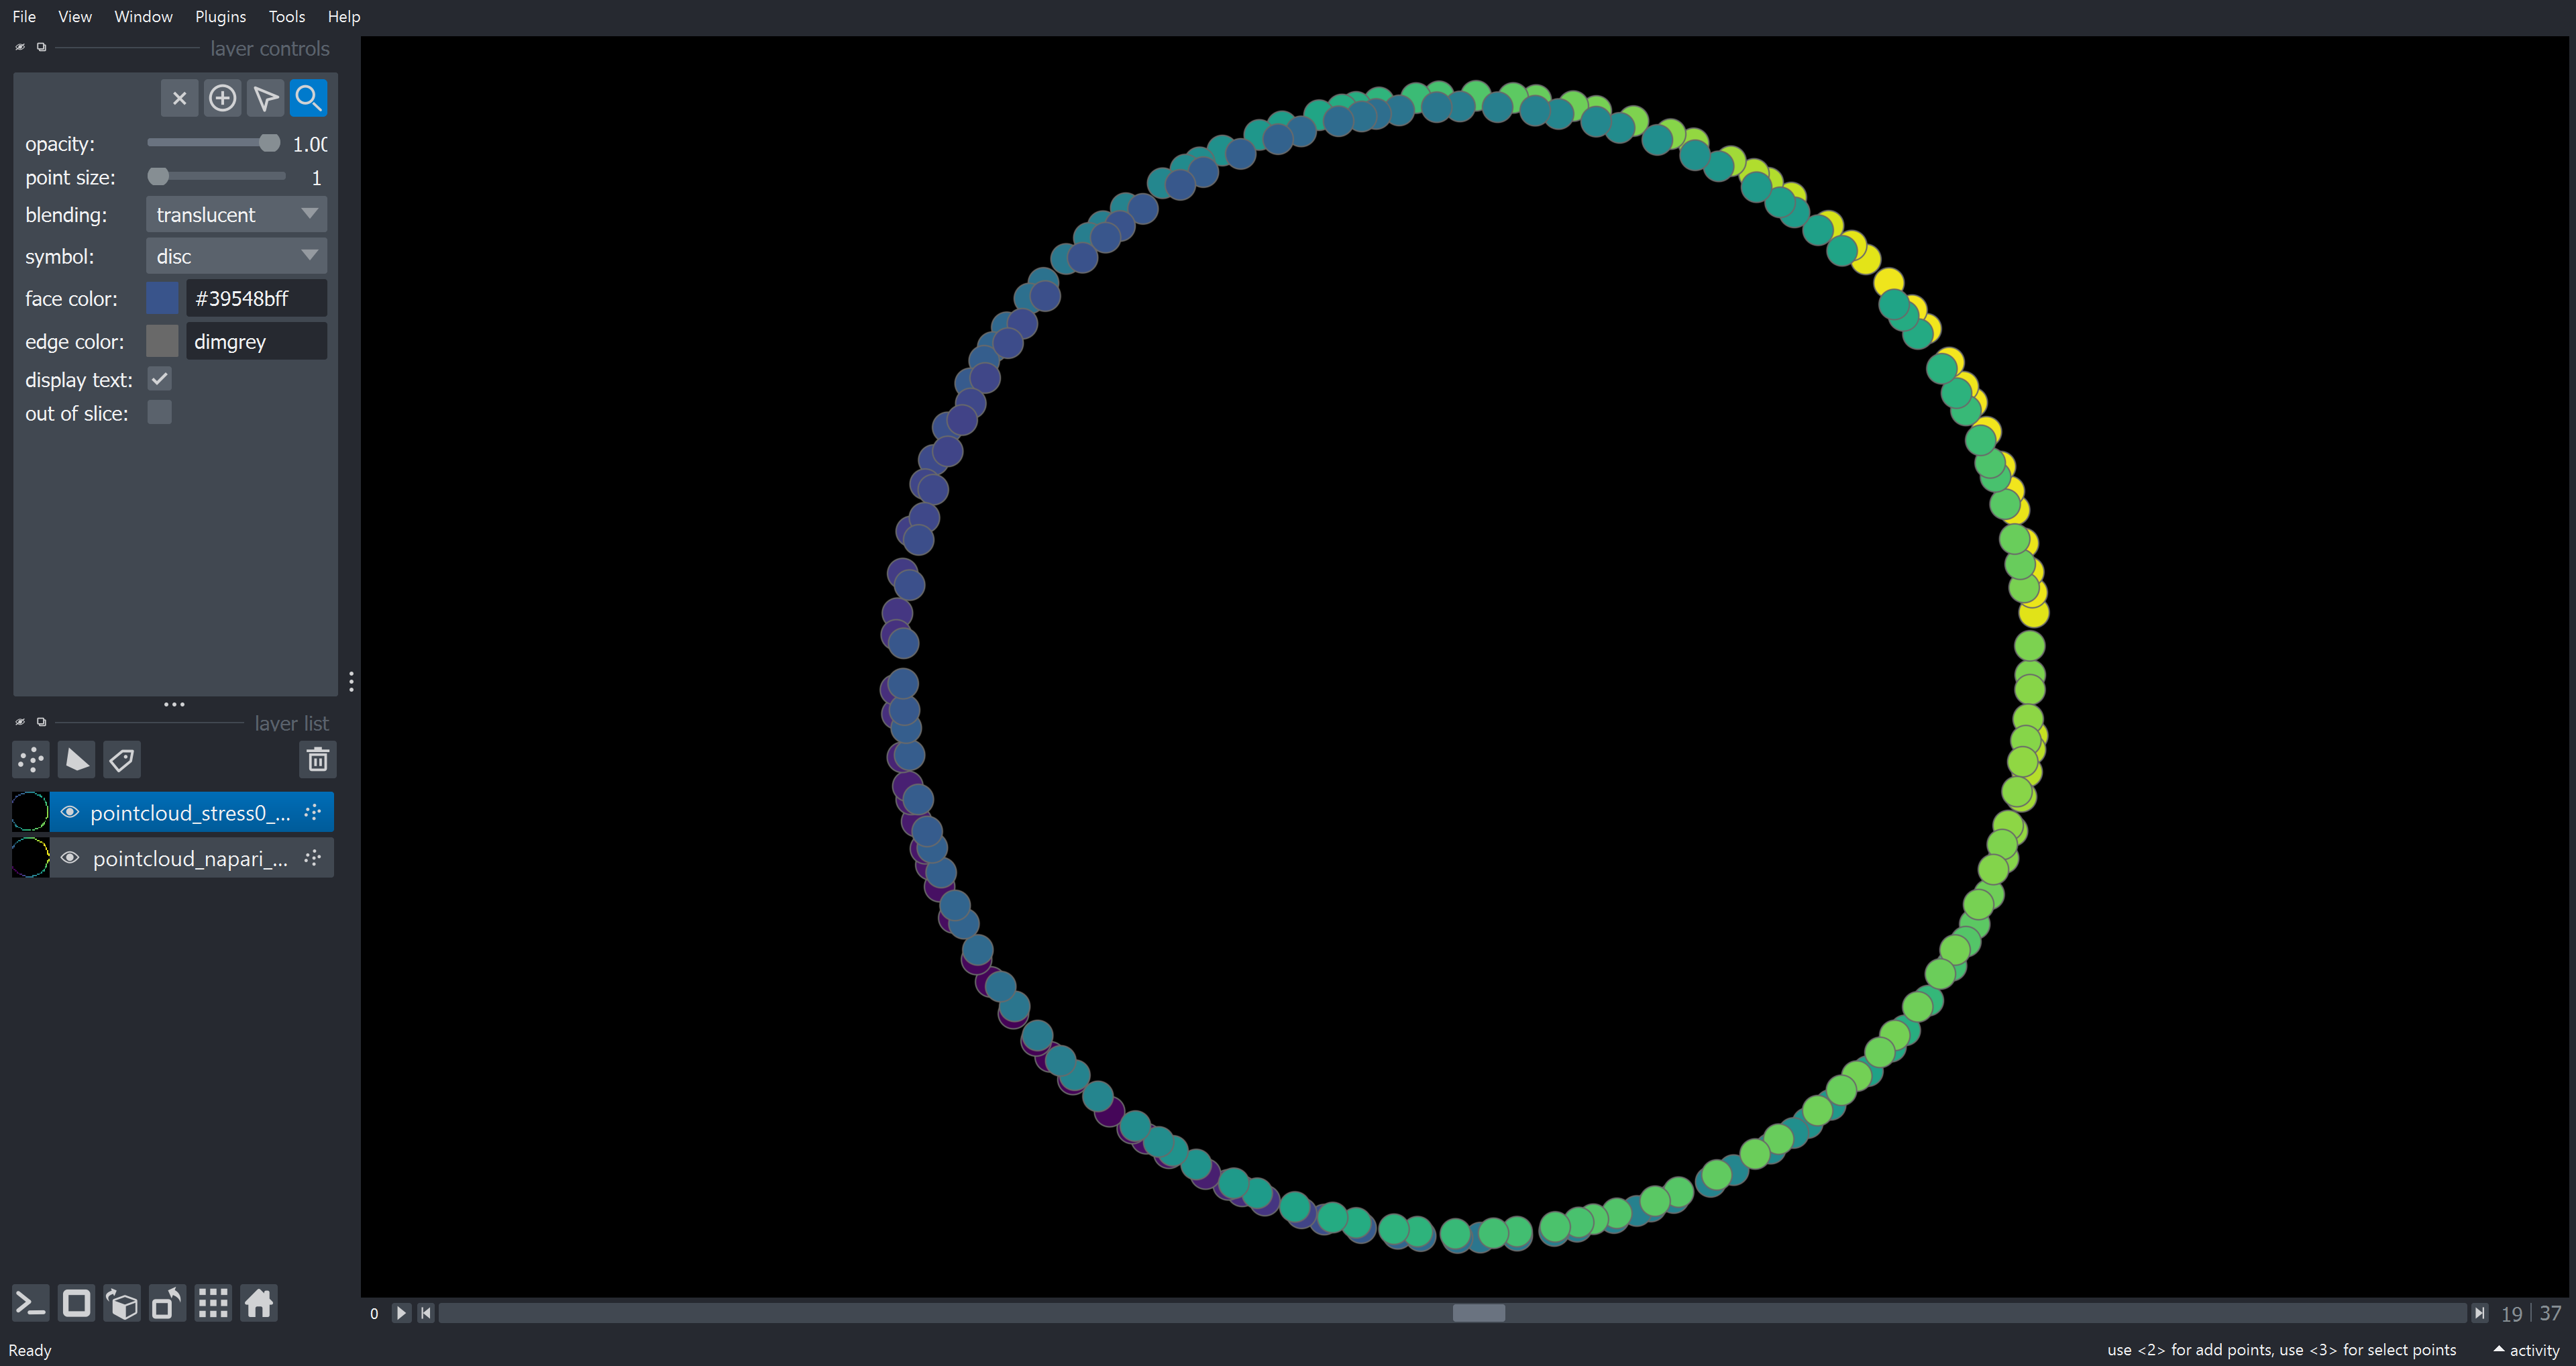

In [94]:
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Mean curvatures

Here, we compare the measured mean curvatures for each of the above-described workflows:

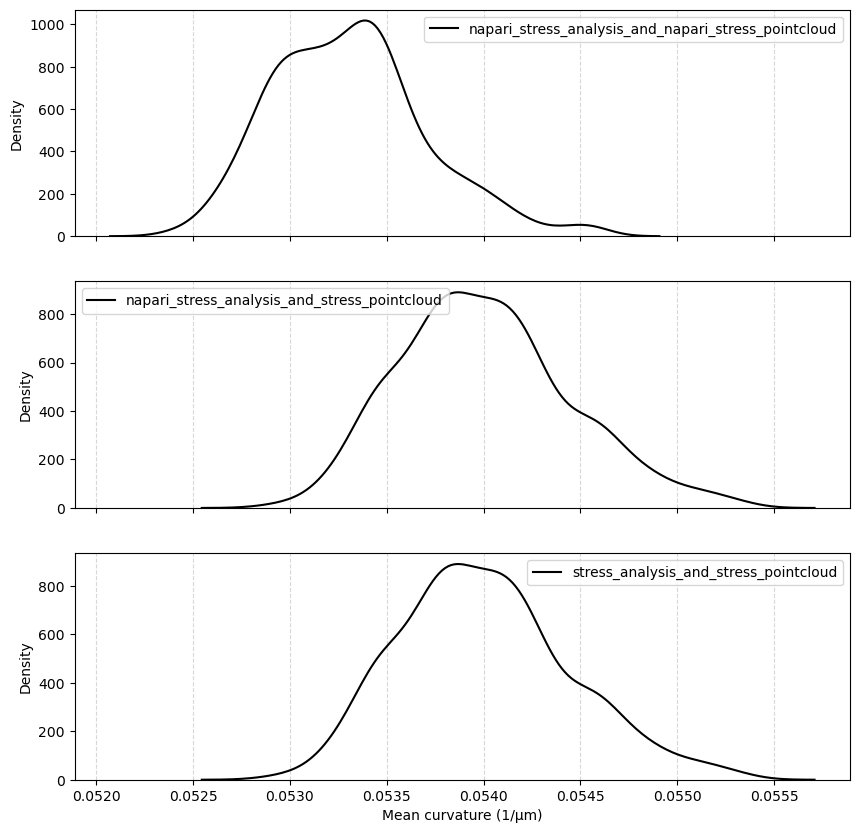

In [95]:
mpl.style.use('default')

fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
file = 'mean_curvatures.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    mean_curvatures = np.loadtxt(os.path.join(dataset, directory, 'mean_curvatures.csv'))
    sns.kdeplot(data=mean_curvatures, ax=axes[idx], label=directory, color='k')
    theoretical_mean_curvature = theoretical_mean_curvature_on_pointcloud(1, 1, 1, pointcloud_napari_stress0_centered)

    axes[idx].set_xlabel('Mean curvature (1/µm)')
    axes[idx].grid(which='major', axis='x', linestyle='--', alpha=0.5)

    axes[idx].legend()
    idx += 1


## Compare stresses

Here we compare total/cell/tissue stresses for the three workflows:

In [96]:
def calculate_anisotropy(values, alpha=0.05):
    from scipy import stats
    hist_data = np.histogram(values, bins='auto', density=True)
    hist_dist = stats.rv_histogram(hist_data)
    smallest_excluded_value = hist_dist.ppf(alpha)
    largest_excluded_value = hist_dist.ppf(1. - alpha)

    return largest_excluded_value - smallest_excluded_value

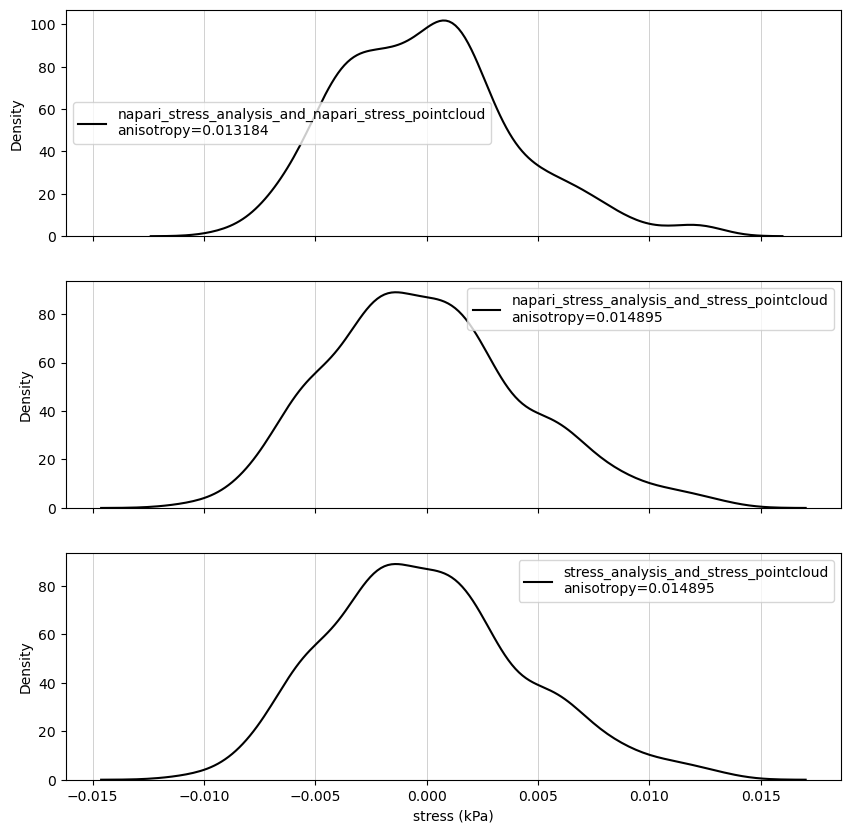

In [97]:
fig, axes = plt.subplots(nrows=3, figsize=(10,10), sharex=True)
file = 'total_stress.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    total_stresses = np.loadtxt(os.path.join(dataset, directory, file))
    anisotropy = calculate_anisotropy(total_stresses)
    sns.kdeplot(data=total_stresses, ax=axes[idx], label=directory+'\nanisotropy={:2f}'.format(anisotropy), color='k')
    axes[idx].set_xlabel('stress (kPa)')
    axes[idx].grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)

    axes[idx].legend()
    idx += 1


# Ellipsoid

In this section, we repeat the analysis workflow from above for synthetic data of an ellipsoid with major axis lengths of (10, 7.5, 7.5).

In [98]:
dataset = os.path.join('.', 'results_ellipsoid')

In [99]:
pointcloud_stress0 = pd.read_csv(os.path.join(dataset, 'stress_analysis_and_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()
pointcloud_napari_stress0 = pd.read_csv(os.path.join(dataset, 'napari_stress_analysis_and_napari_stress_pointcloud', 'pointcloud.csv'), sep=' ', header=None).to_numpy()

It is not clear whether the process of creating the synthetic image data delivers an ellipsoid image with the same major axis lengths which were used to create the initial pointcloud (see [this notebook](./create_validation_data.ipynb)). Hence, we calculate the correct ellipsoidal axis lengths ourselves here:

In [120]:
axis_lengths = (pointcloud_napari_stress0.max(axis=0) - pointcloud_napari_stress0.min(axis=0))/2
axis_lengths = np.sort(axis_lengths)[::-1]
print('a = {:.2f} px, b = {:.2f} px, c = {:.2f} px'.format(*axis_lengths))

a = 18.15 px, b = 13.77 px, c = 13.75 px


In [100]:
viewer2 = napari.Viewer()

Again, we center the pointclouds to be able to compare them better on top of each other:

In [106]:
pointcloud_stress0_centered = pointcloud_stress0 - pointcloud_stress0.mean(axis=0)[None, :]
pointcloud_napari_stress0_centered = pointcloud_napari_stress0 - pointcloud_napari_stress0.mean(axis=0)[None, :]

In [107]:
viewer2.add_points(pointcloud_stress0_centered, size=0.5, name='pointcloud STRESS')
viewer2.add_points(pointcloud_napari_stress0_centered, size=0.5, face_color='orange', name='pointcloud napari stress')

<Points layer 'pointcloud napari stress [1]' at 0x2963925d3a0>

It carries limited information for ellipsoidal data, but for completeness we also measure the radii of each point in spherical coordinates:

In [ ]:
r_ns, phi_ns, theta_ns = vedo.cart2spher(pointcloud_napari_stress0_centered[:, 0], pointcloud_napari_stress0_centered[:, 1], pointcloud_napari_stress0_centered[:, 2])
r_s, phi_s, theta_s = vedo.cart2spher(pointcloud_stress0_centered[:, 0], pointcloud_stress0_centered[:, 1], pointcloud_stress0_centered[:, 2])

mpl.style.use('default')
fig, ax = plt.subplots()
ax.hist(r_ns, 50, label='napari-stress, $\sigma$ = {:.2f} µm'.format(r_ns.std()), alpha=0.5)
ax.hist(r_s, 50, label='STRESS, $\sigma$ = {:.2f} µm'.format(r_s.std()), alpha=0.5)
ax.legend()

## Mean curvatures

We now plot the distribution of mean curvatures on the synthetic ellipsoid for the three experimental workflows described above:

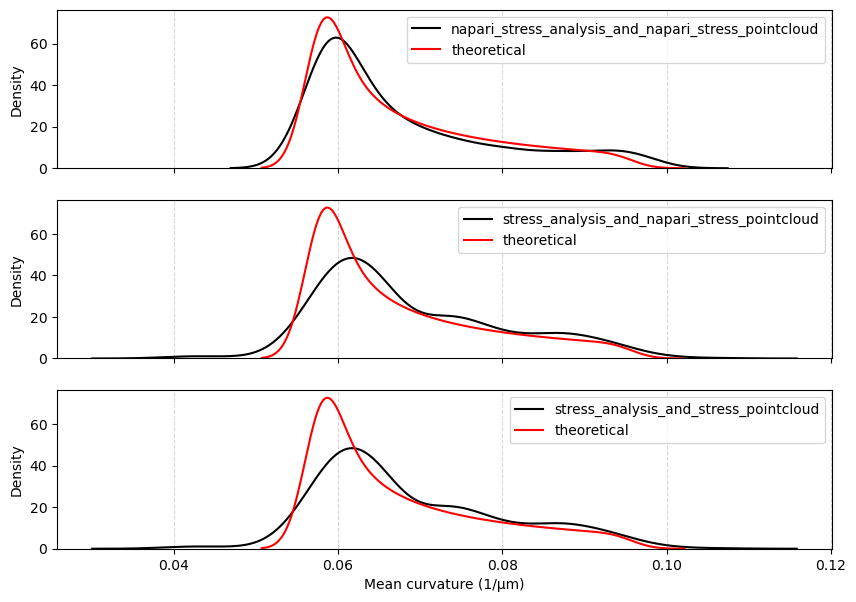

In [121]:
mpl.style.use('default')

fig, axes = plt.subplots(nrows=3, figsize=(10,7), sharex=True)
file = 'mean_curvatures.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    mean_curvatures = np.loadtxt(os.path.join(dataset, directory, 'mean_curvatures.csv'))
    mean_curvatures_theoretical = theoretical_mean_curvature_on_pointcloud(axis_lengths[0], axis_lengths[1], axis_lengths[2], pointcloud_napari_stress0_centered)
    sns.kdeplot(data=mean_curvatures, ax=axes[idx], label=directory, color='k')
    sns.kdeplot(data=mean_curvatures_theoretical, ax=axes[idx], label='theoretical', color='r')

    axes[idx].set_xlabel('Mean curvature (1/µm)')
    axes[idx].grid(which='major', axis='x', linestyle='--', alpha=0.5)

    axes[idx].legend()
    idx += 1


## Total stress

We plot the same curve for total stress:

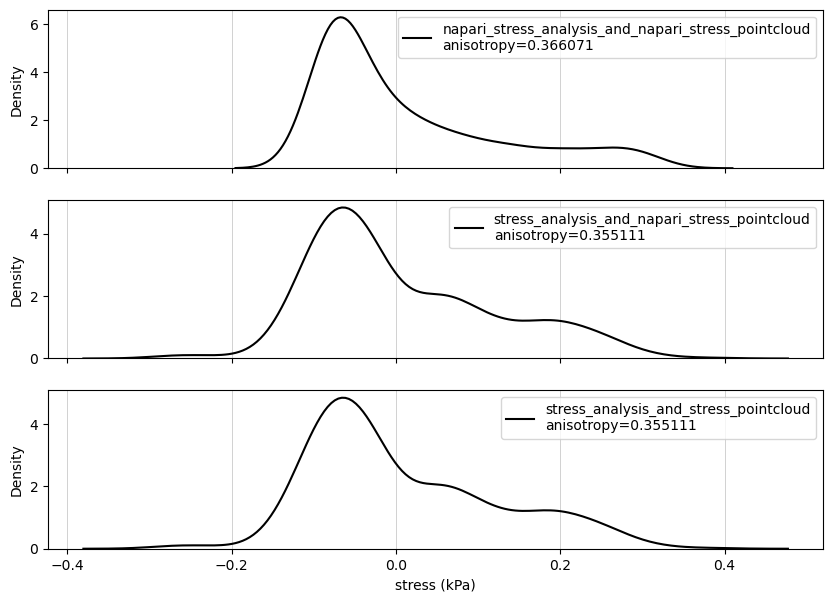

In [111]:
fig, axes = plt.subplots(nrows=3, figsize=(10,7), sharex=True)
file = 'total_stress.csv'
idx = 0
for _, directory in enumerate(os.listdir(dataset)):
    if not os.path.isdir(os.path.join(dataset, directory)):
        continue

    total_stresses = np.loadtxt(os.path.join(dataset, directory, file))
    anisotropy = calculate_anisotropy(total_stresses)
    sns.kdeplot(data=total_stresses, ax=axes[idx], label=directory+'\nanisotropy={:2f}'.format(anisotropy), color='k')
    axes[idx].set_xlabel('stress (kPa)')
    axes[idx].grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)

    axes[idx].legend()
    idx += 1
